In [92]:
import pandas as pd
import nltk
import json
import gensim
import tqdm

### Get text and load as a DataFrame

In [93]:
## Get text and load as a DataFrame

nltk.download('punkt')

def read_book_to_dataframe(file_path):
    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Split the text into sentences
    sentences = nltk.tokenize.sent_tokenize(text)

    # Create a DataFrame
    df = pd.DataFrame(sentences, columns=['Sentence'])

    return df

# Using the .txt file that's in the same directory
file_path = 'anna_karenina.txt'
df = read_book_to_dataframe(file_path)

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evanwineland/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Sentence
0,PART ONE\nChapter 1\nHappy families are all alike; every unhappy family is unhappy in its own way.
1,Everything was in confusion in the Oblonskys’ house.
2,"The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on liv..."
3,"This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were painfully conscious of it."
4,"Every person in the house felt that there was no sense in their living together, and that the stray people brought together by chance in any inn had more in common with one another than they, the ..."


In [94]:
## Note: install spacy at the command line first.  Then, download en_core_web_sim
import re
import bs4
import requests
import spacy
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

# nlp = spacy.load("en_core_web_sm")

pd.set_option('display.max_colwidth', 200)

In [95]:
nlp = spacy.load("en_core_web_sm")

In [96]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # only analyze if the current token isn't punctuation
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [97]:
df.shape[0], df.head()

(16807,
                                                                                                                                                                                                   Sentence
 0                                                                                                       PART ONE\nChapter 1\nHappy families are all alike; every unhappy family is unhappy in its own way.
 1                                                                                                                                                     Everything was in confusion in the Oblonskys’ house.
 2  The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on liv...
 3                     This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were

In [98]:
get_entities(df['Sentence'][0])

['unhappy  family', 'own  way']

In [99]:
e_pairs = []

for i in tqdm(df["Sentence"]):
    e_pairs.append(get_entities(i))

100%|████████████████████████████████████| 16807/16807 [01:51<00:00, 150.67it/s]


In [100]:
e_pairs[0:10]

[['unhappy  family', 'own  way'],
 ['Everything', 'Oblonskys  house'],
 ['she', 'same  him'],
 ['only  husband', 'painfully  it'],
 ['stray  people', 'common  Oblonskys'],
 ['own  husband', 'three  days'],
 ['just kitchen coachman', 'warning'],
 ['days Stepan Arkadyevitch he', 'covered  study'],
 ['once  he', 'eyes'],
 ['now  he', 'dream']]

In [101]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [102]:
get_relation("Kaan finished the race.")

'finished'

In [103]:
relations = [get_relation(i) for i in df["Sentence"]]
relations[:50]

['is unhappy',
 'was in',
 'discovered',
 'lasted',
 'felt',
 'been at',
 'walked off',
 'woke',
 'embraced',
 'thought',
 'was',
 'be sure',
 'giving',
 'was in',
 'remembered',
 'twinkled',
 'was nice',
 'dropped',
 'stretched',
 'remembered',
 'Ah',
 'muttered',
 'was present',
 'forgive',
 'is',
 'reflected',
 'kept',
 'was',
 'fussing',
 '’s',
 'this',
 'was',
 'happened to',
 'succeed in',
 'reflected',
 'smile',
 'shuddered',
 'refused',
 'thought',
 '’s',
 'said to',
 'was',
 'was incapable',
 'at',
 'was',
 'felt',
 'managed',
 'thought',
 'supposed',
 'turned']

### Create and visualize the KG using entities and relationships

In [104]:
source = [i[0] for i in e_pairs]
target = [i[1] for i in e_pairs]

In [105]:
kg_df = pd.DataFrame({'source': source, 'target': target, 'relation': relations})
kg_df.head()

,source,target,relation
0,unhappy family,own way,is unhappy
1,Everything,Oblonskys house,was in
2,she,same him,discovered
3,only husband,painfully it,lasted
4,stray people,common Oblonskys,felt


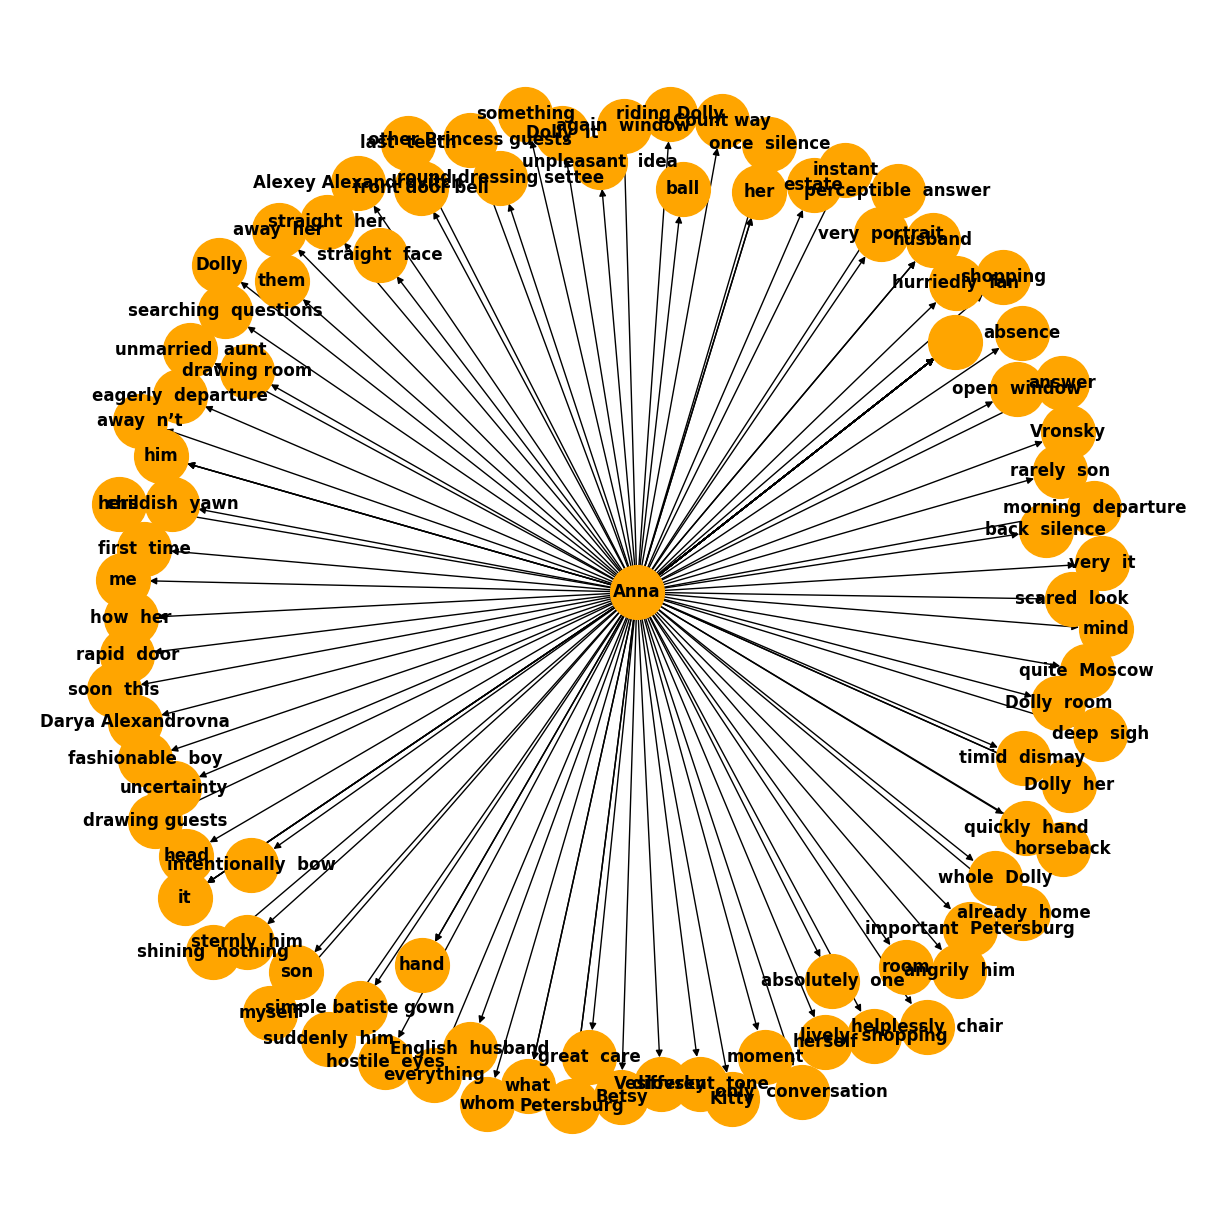

In [106]:
graph = nx.from_pandas_edgelist(kg_df[kg_df['source']=="Anna"], "source", "target", edge_attr = True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = .5)
nx.draw(graph, with_labels=True, node_color = 'orange', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight = 'bold')

plt.show()

Getting edge labels required I compromise on having a directed graph with multiple edges between nodes.

I also want to limit the number of these that I have.

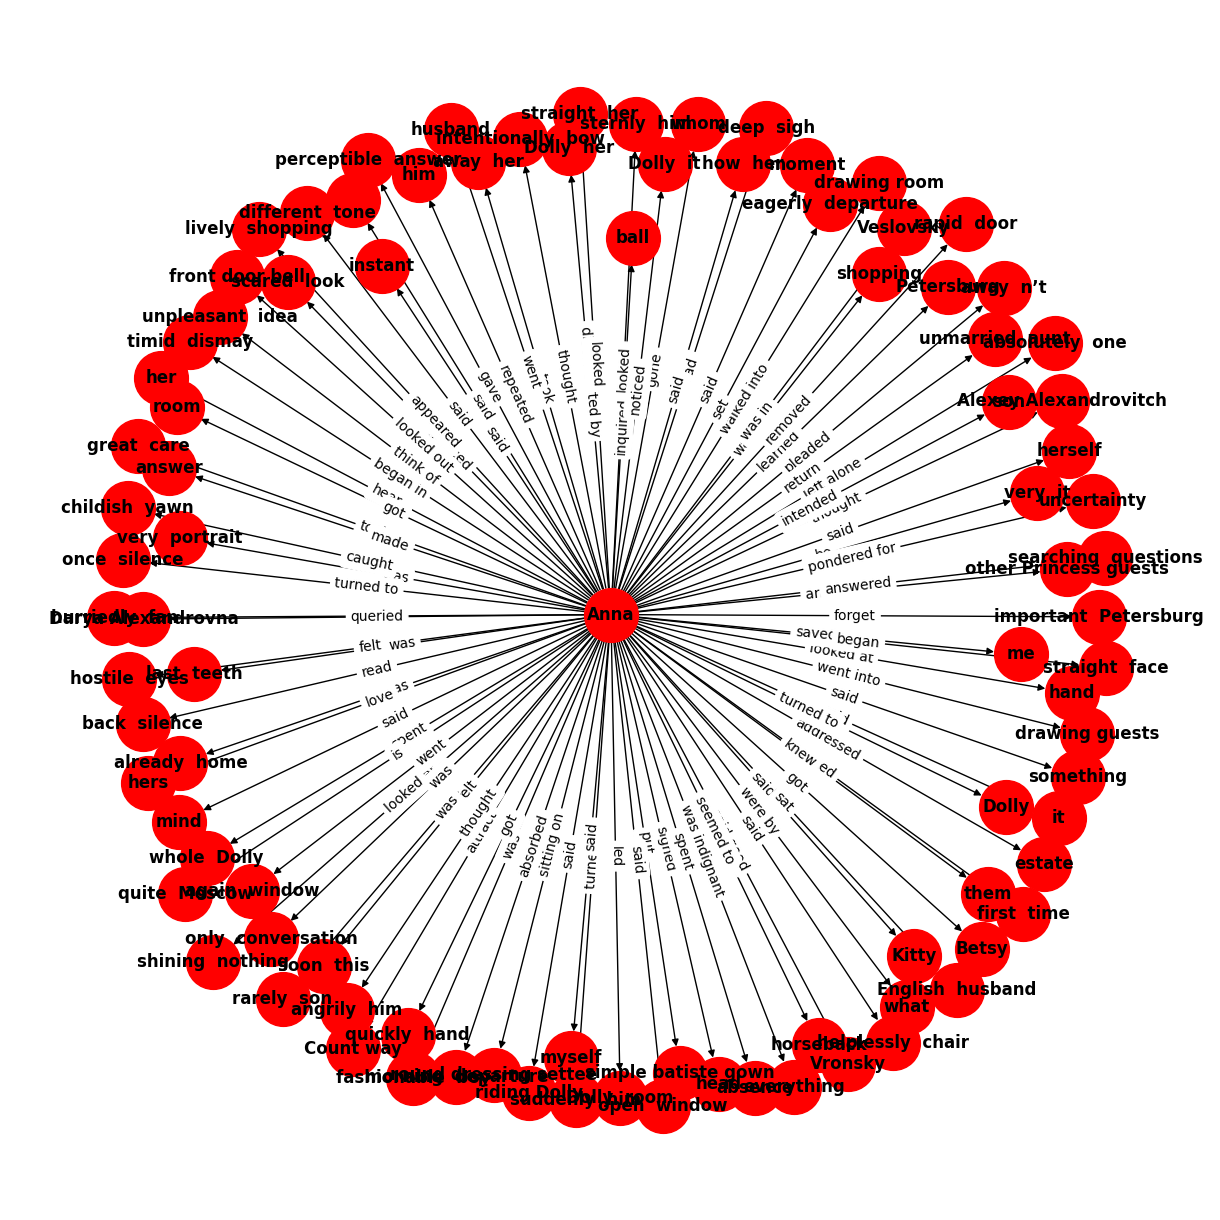

In [107]:
## Make the graph, but with labeled edges
graph = nx.from_pandas_edgelist(kg_df[kg_df['source']=="Anna"], "source", "target", edge_attr = True, create_using=nx.DiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = .5)
nx.draw(graph, with_labels=True, node_color = 'red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight = 'bold')

#Draw labels
edge_labels = nx.get_edge_attributes(graph, 'relation')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()

### Some quick entity normalization

Let's do a quick pass to make sure all Anna, Stepan, Vronsky, and Karenin nodes are treated as the same entity.

In [108]:
pd.Series(source).value_counts()[:50]

he                       1422
                          982
she                       859
I                         811
He                        382
it                        375
you                       290
She                       275
Levin                     250
who                       196
that                      178
they                      164
Stepan Arkadyevitch       133
It                        130
Anna                      127
Vronsky                   124
Kitty                     107
You                        95
Alexey Alexandrovitch      83
They                       80
we                         78
what                       71
when  he                   69
which                      67
Sergey Ivanovitch          59
one                        56
We                         48
this                       44
him                        43
when  she                  37
so  he                     37
how  he                    32
Darya Alexandrovna         32
That      

In [151]:
def replace_pronouns(df):
    pronouns = ["he", "she"]
    allowed_replacement_names = ["Anna", "Anna Arkadyevna", "Stepan Arkadyevitch", "Stiva", "Oblonsky",
                                 "Konstantin Dmitrievich", "Konstantin", "Levin", "Kostya", "Kitty", "Vronsky", 
                                 "Darya Alexandrovna", "Dolly", "Karenin", "Alexei Alexandrovich"]

    for i in range(len(df)):
        current_entity = df['source'][i].lower()

        if (i > 0) and (current_entity in pronouns):
            j = i - 1

            # Iterate backwards to find the nearest allowed replacement name
            while (j >= 0):
                previous_entity = df['source'][j]

                if previous_entity in allowed_replacement_names:
                    df['source'][i] = previous_entity
                    break
                j -= 1

    return df


In [152]:
kg_df = replace_pronouns(kg_df)
pd.Series(kg_df['source']).value_counts()[:50]

source
Levin                    1126
                          982
I                         811
Vronsky                   799
Anna                      791
Stiva                     482
Kitty                     407
it                        375
you                       290
who                       196
that                      178
they                      164
It                        130
Dolly                     123
You                        95
Alexey Alexandrovitch      83
They                       80
we                         78
what                       71
when  he                   69
which                      67
Sergey Ivanovitch          59
one                        56
We                         48
this                       44
him                        43
when  she                  37
so  he                     37
how  he                    32
That                       31
her                        31
now  he                    31
how  it                    29
eye

In [154]:
kg_df[:50]

,source,target,relation
0,unhappy family,own way,is unhappy
1,Everything,Oblonskys house,was in
2,she,same him,discovered
3,only husband,painfully it,lasted
4,stray people,common Oblonskys,felt
5,own husband,three days,been at
6,just kitchen coachman,warning,walked off
7,days Stepan Arkadyevitch he,covered study,woke
8,once he,eyes,embraced
9,now he,dream,thought


In [155]:
# With more proper nouns, now consolidate into the same entity.  Will do the quick-and-dirty way
def normalize_entities(df):
    
    # Want to consolidate into Anna, Stiva, Levin,
    names_map = {
                    'Anna Arkadyevna': 'Anna',
                    'Stepan Arkadyevitch': 'Stiva',
                    'Oblonsky': 'Stiva',
                    'Konstantin Dmitrievich': 'Levin',
                    'Konstantin': 'Levin',
                    'Kostya': 'Levin',
                    'Darya Alexandrovna': 'Dolly'
                }
    
    for i in range(len(df)):
        
        current_entity = df['source'][i]
        if current_entity in names_map.keys():
            df['source'][i] = names_map[current_entity]
            
    return df

In [156]:
normalize_entities(kg_df)
pd.Series(kg_df['source']).value_counts()[:50]

source
Levin                    1126
                          982
I                         811
Vronsky                   799
Anna                      791
Stiva                     482
Kitty                     407
it                        375
you                       290
who                       196
that                      178
they                      164
It                        130
Dolly                     123
You                        95
Alexey Alexandrovitch      83
They                       80
we                         78
what                       71
when  he                   69
which                      67
Sergey Ivanovitch          59
one                        56
We                         48
this                       44
him                        43
when  she                  37
so  he                     37
how  he                    32
That                       31
her                        31
now  he                    31
how  it                    29
eye

In [157]:
pd.Series(kg_df['source']=='Oblonsky').value_counts()

source
False    16807
Name: count, dtype: int64

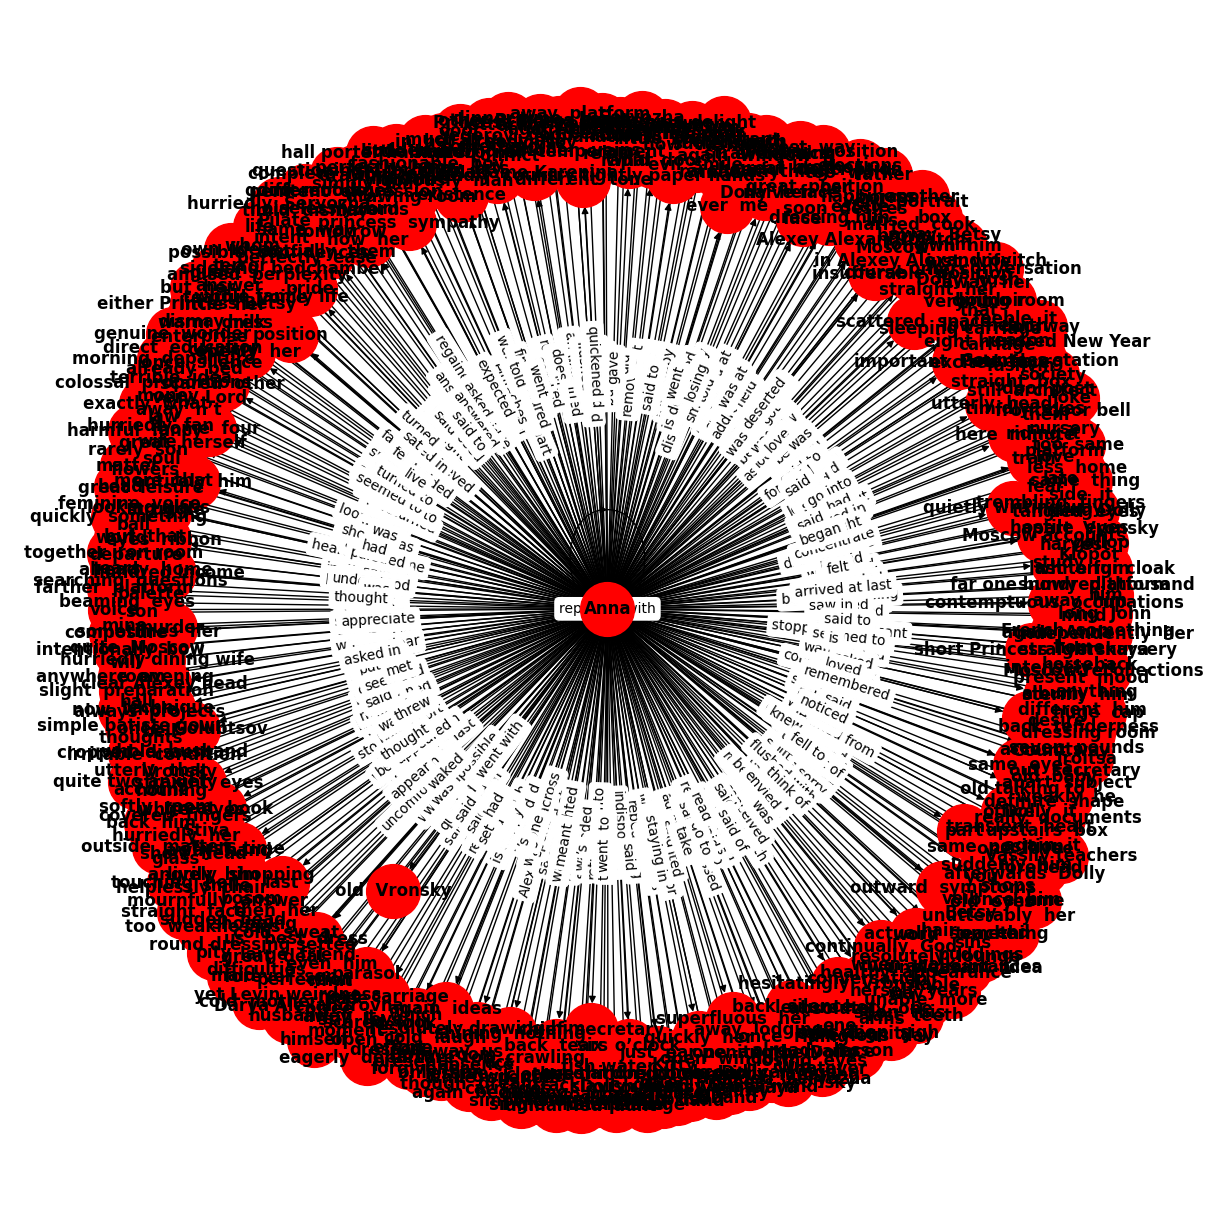

In [159]:
## Make a graph for Anna, but with labeled edges
anna_graph = nx.from_pandas_edgelist(kg_df[kg_df['source']=="Anna"], "source", "target", edge_attr = True, create_using=nx.DiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = .5)
nx.draw(graph, with_labels=True, node_color = 'red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight = 'bold')

#Draw labels
edge_labels = nx.get_edge_attributes(graph, 'relation')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()

In [ ]:
## Make a graph for Vronsky
anna_graph = nx.from_pandas_edgelist(kg_df[kg_df['source']=="Anna"], "source", "target", edge_attr = True, create_using=nx.DiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = .5)
nx.draw(graph, with_labels=True, node_color = 'red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight = 'bold')

#Draw labels
edge_labels = nx.get_edge_attributes(graph, 'relation')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()